# Calibration of NaI(Te) scintillator with two samples:
>    22Na with 2 peaks and 2 visible Compton edges
>
>137Cs with one photo peak, compton edge and escape peak

In [24]:
%matplotlib inline

In [23]:
# %load preamb.py
import numpy as np
import pylab as plt
from matplotlib import rcParams
from scipy.optimize import curve_fit
import scipy.constants as co
import uncertainties as uc
import uncertainties.unumpy as un
from scipy.signal import argrelextrema as ext
from scipy.signal import savgol_filter as sav
import seaborn as sns
from scipy.special import erfc
from scipy.integrate import quad
import sys

sns.set(style='ticks', palette='Set2')
sns.despine()

fontsize_labels = 22    # size used in latex document
rcParams['font.family'] = 'serif'
rcParams['font.serif'] = ['Computer Modern Roman']
rcParams['text.usetex'] = True
rcParams['figure.autolayout'] = True
rcParams['font.size'] = fontsize_labels
rcParams['axes.labelsize'] = fontsize_labels
rcParams['xtick.labelsize'] = fontsize_labels
rcParams['ytick.labelsize'] = fontsize_labels
rcParams['legend.fontsize'] = fontsize_labels
rcParams['figure.figsize'] = (2*6.2, 2*3.83)  # in inches; width corresponds to \textwidth in latex document (golden ratio)

plt.close("all")
show_fig = True
save_fig = False # see below
if not save_fig:
        rcParams['figure.figsize'] = (13, 8)
        fig_dir = "../figures/"
        npy_dir = "./data_npy/"


In [3]:
def gauss(x, *p):
    A, mu, sigma, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2)) + offset

def gauss_plus_exp(x, *p):
    A, mu, sigma, C, lamb, offset = p
    return  A * np.exp(-(x - mu)**2 / (2. * sigma**2))  + \
            C * np.exp(lamb * (x - x_min)) + \
            offset

def conv_analytical(x, *p):
    '''
    analytical solution of convolution of step and gauss
    as a crude approximation of klein nishima
    '''
    A_edge, x_step, sigma, offset = p
    return A_edge / 2 * erfc((x - x_step) / (np.sqrt(2) * sigma))  + offset

def peak_and_edge(x, *p):
    '''
    combines gauss peak and analytical solution to stepfunction convoluted with gauss
    '''
    A_peak, mu, sigma_peak, A_edge, x_max, sigma_edge, offset = p
    peak = A_peak * np.exp(-(x - mu)**2 / (2. * sigma_peak**2))
    edge = A_edge / 2 * erfc((x - x_max) / (np.sqrt(2) * sigma_edge))
    return(peak + edge + offset)

Background
----------------

In [4]:
#### Background ####
file_in = npy_dir + "na_background" + '.npy'
y_bg = np.load(file_in)
y_bg_e = un.uarray(y_bg, np.maximum(1, np.sqrt(y_bg)))

t_bg = 3600  # Real time
rate_bg = y_bg / t_bg
rate_bg_e = y_bg_e / t_bg

$^{137}$Cs Sample
-----------------

In [12]:
file_in = npy_dir + "na_137cs_01" + '.npy'
y = np.load(file_in)
x = np.arange(len(y))
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

t = 9742   
rate = y / t
rate = rate - rate_bg
rate[rate < 0] = 0
rate_e = y_e / t - rate_bg_e
rate_e[rate < 0] = 0 

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e


### Fits:
* Photo peak: 662 keV
* Compton edge: 477 keV
* Escape peak: 183 keV


In [13]:
###### PHOTO PEAK #################
# Define range to be fitted
x_min = 7000    # lower bound
x_max = 9000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, offset]
p0 = [0.7, 8000, 400, 0.03]
coeff, var_matrix = curve_fit(gauss, x_fit, y_fit, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
fit_photo = gauss(x_fit, *coeff)


###### COMPTON EDGE  #################
# Define range to be fitted
x_min = 5000    # lower bound
x_max = 6500    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit2 = x[mask]
y_fit2 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edge, x_step, sigma, offset]
p0 = [ 0.12,  5700,   330,   0.03]
coeff2, var_matrix2 = curve_fit(conv_analytical, x_fit2, y_fit2, p0=p0,
                                sigma=y_sigma, absolute_sigma=True)
fit_edge = conv_analytical(x_fit2, *coeff2)
x_step = coeff2[1]


###### ESCAPE PEAK #################
# Define range to be fitted
x_min = 1800    # lower bound
x_max = 3000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, offset]
p0 = [0.02, 2300, 200, 0.16]
coeff3, var_matrix3 = curve_fit(gauss, x_fit3, y_fit3, p0=p0,  
                                sigma=y_sigma, absolute_sigma=True)
fit_escape = gauss(x_fit3, *coeff3)

'''
###### PEAK AND EDGE  #################
# Define range to be fitted
x_min = 5000    # lower bound
x_max = 10000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit4 = x[mask]
y_fit4 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_peak, mu, sigma_peak, A_edge, x_step, sigma_edge, offset]
p0 = [7000, 8000, 400, 1200, 5700, 330, 300]
coeff4, var_matrix = curve_fit(peak_and_edge, x_fit4, y_fit4, p0=p0,  
                                sigma=y_sigma, absolute_sigma=True)
fit_peak_and_edge = peak_and_edge(x_fit4, *coeff4)
'''

'\n###### PEAK AND EDGE  #################\n# Define range to be fitted\nx_min = 5000    # lower bound\nx_max = 10000    # upper bound\nmask = (x > x_min) * (x < x_max)\nx_fit4 = x[mask]\ny_fit4 = y[mask]\ny_sigma = np.sqrt(un.std_devs(y_e[mask]))\n\n# p0 is the initial guess for the fitting coefficients\n# p = [A_peak, mu, sigma_peak, A_edge, x_step, sigma_edge, offset]\np0 = [7000, 8000, 400, 1200, 5700, 330, 300]\ncoeff4, var_matrix = curve_fit(peak_and_edge, x_fit4, y_fit4, p0=p0,  \n                                sigma=y_sigma, absolute_sigma=True)\nfit_peak_and_edge = peak_and_edge(x_fit4, *coeff4)\n'

## Plotting results

/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


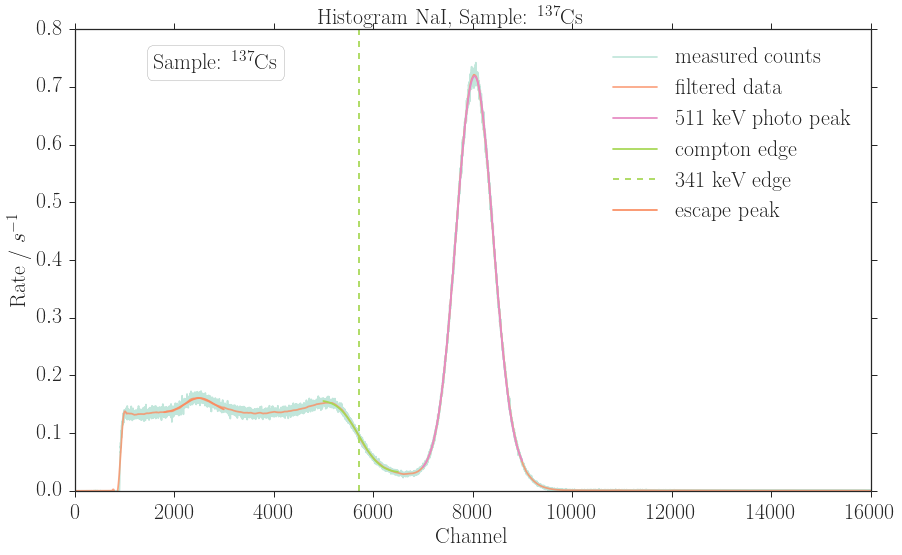

In [14]:
fig1, ax1 = plt.subplots(1, 1)
sample_name = '$^{137}\mathrm{Cs}$'
if not save_fig:
    fig1.suptitle("Histogram NaI, Sample: " + sample_name)
#ax1.plot(x, rate_bg, '.', alpha=0.9, label='background')
ax1.plot(x, y, '-', alpha=0.4, label=('measured counts'))
#next(ax1._get_lines.color_cycle)
ax1.plot(x, y_filtered, '-', alpha=0.8, label=('filtered data'))
next(ax1._get_lines.color_cycle)
ax1.plot(x_fit, fit_photo, label='511 keV photo peak')
edge, = ax1.plot(x_fit2, fit_edge, label='compton edge')
ax1.plot([x_step] * 2, [0, 0.8], '--', c=edge.get_color(), label='341 keV edge')
next(ax1._get_lines.color_cycle)
ax1.plot(x_fit3, fit_escape, label='escape peak')
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'Sample: ' + sample_name
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)
ax1.set_xlim(0, 16000)
ax1.set_ylim(0, 0.8)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.legend(loc=1)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "histo_na_137cs"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")


### Save parameters

In [15]:
cs_photo = uc.ufloat(coeff[1], var_matrix[1, 1])
cs_compton = uc.ufloat(coeff2[1], var_matrix2[1, 1])
cs_escape = uc.ufloat(coeff3[1], var_matrix3[1, 1])


# Use sigma for errors!
cs_photo = uc.ufloat(coeff[1], coeff[2])
cs_compton= uc.ufloat(coeff2[1], coeff2[2])
cs_escape = uc.ufloat(coeff3[1], coeff3[2])

$^{22}$Na Sample
----------------

### Fits:
* Photo peak 1: 511 keV
* Compton edge 1: 341 keV (hardly visible)
* Photo peak 2: 1277 keV
* Compton edge 2: 1064 keV


In [16]:
file_in = npy_dir + "na_22na_02" + '.npy'
y = np.load(file_in)
x = np.arange(len(y))
y_e = un.uarray(y, np.maximum(1, np.sqrt(y)))

t = 4102  
rate = y / t
rate = rate - rate_bg # the background is quite hugh!
rate[rate < 0] = 0
rate_e = y_e / t - rate_bg_e
rate_e[rate < 0] = 0 

y = rate
y_filtered = sav(y, 301, 4)
y_e = rate_e

In [17]:
###### PEAK 1 #################
# Define range to be fitted
x_min = 5800    # lower bound
x_max = 8000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit = x[mask]
y_fit = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))


# p0 is the initial guess for the fitting coefficients
# p = [A, mu, sigma, C, lamb, offset]
p0 = [0.03, 6200, 340, 0.003]
coeff, var_matrix = curve_fit(gauss, x_fit, y_fit, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
fit_peak1 = gauss(x_fit, *coeff)

###### PEAK 2 #################
# Define range to be fitted
x_min = 12500    # lower bound
x_max = 16000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit2 = x[mask]
y_fit2 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A, mu, sigma, offset]
p0 = [0.003, 14200, 400, 0.001]
coeff2, var_matrix2 = curve_fit(gauss, x_fit2, y_fit2, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
fit_peak2 = gauss(x_fit2, *coeff2)

###### COMPTON EDGE 2 #################
# Define range to be fitted
x_min = 11290    # lower bound
x_max = 13150    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit3 = x[mask]
y_fit3 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edga, x_step, sigma, offset]
p0 = [0.001, 12000, 400, 1e-3]
coeff3, var_matrix3 = curve_fit(conv_analytical, x_fit3, y_fit3, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
fit_edge = conv_analytical(x_fit3, *coeff3)
x_step3 = coeff3[1]

###### COMPTON EDGE 1 #################
# Define range to be fitted
x_min = 3600    # lower bound
x_max = 5000    # upper bound
mask = (x > x_min) * (x < x_max)
x_fit4 = x[mask]
y_fit4 = y[mask]
y_sigma = np.sqrt(un.std_devs(y_e[mask]))

# p0 is the initial guess for the fitting coefficients
# p = [A_edga, x_step, sigma, offset]
p0 = [0.01, 4000, 400, 1e-3]
fit_edge4 = conv_analytical(x_fit4, *p0)
coeff4, var_matrix4 = curve_fit(conv_analytical, x_fit4, y_fit4, p0=p0,
                              sigma=y_sigma, absolute_sigma=True)
fit_edge4 = conv_analytical(x_fit4, *coeff4)
x_step4 = coeff4[1]



/usr/lib/python3/dist-packages/matplotlib/figure.py:372: UserWarning: matplotlib is currently using a non-GUI backend, so cannot show the figure
  "matplotlib is currently using a non-GUI backend, "
/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


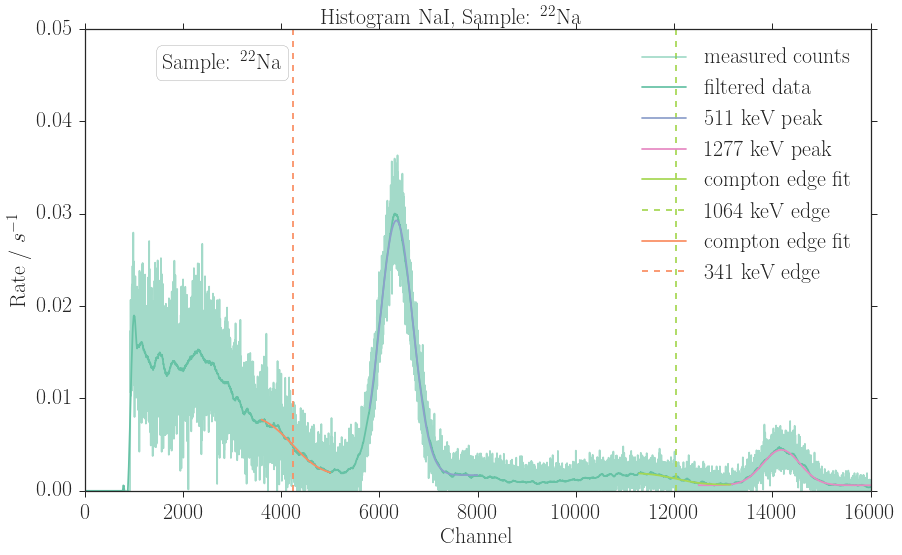

In [19]:
# Plotting
fig1, ax1 = plt.subplots(1, 1)
sample_name = '$^{22}\mathrm{Na}$'
if not save_fig:
    fig1.suptitle("Histogram NaI, Sample: " + sample_name)
#ax1.plot(x, rate_bg, '.', alpha=0.9, label='background')
counts, =ax1.plot(x, y, '-', alpha=0.6, label=('measured counts'))
ax1.plot(x, y_filtered, '-', alpha=1.0, c=counts.get_color(), label=('filtered data'))
#_next(ax1._get_lines.color_cycle)
ax1.plot(x_fit, fit_peak1, label='511 keV peak')
#next(ax1._get_lines.color_cycle)
ax1.plot(x_fit2, fit_peak2, label='1277 keV peak')
edge3, = ax1.plot(x_fit3, fit_edge, label='compton edge fit')
ax1.plot([x_step3] * 2, [0, 0.8], '--', c=edge3.get_color(), label='1064 keV edge')
next(ax1._get_lines.color_cycle)
edge4, = ax1.plot(x_fit4, fit_edge4, label='compton edge fit')
ax1.plot([x_step4] * 2, [0, 0.8], '--', c=edge4.get_color(), label='341 keV edge')
props = dict(boxstyle='round', facecolor='white', alpha=0.5)
textstr = 'Sample: ' + sample_name
ax1.text(0.1, 0.95, textstr, transform=ax1.transAxes, va='top', bbox=props)
ax1.set_xlim(0, 16000)
ax1.set_ylim(0, 0.05)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Rate / $s^{-1}$")
ax1.legend(loc=1)
if show_fig:
    fig1.show()
if save_fig:
    file_name = "histo_na_22na"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")

### Save parameters

In [20]:
na_photo1 = uc.ufloat(coeff[1], var_matrix[1, 1])
na_photo2 = uc.ufloat(coeff2[1], var_matrix2[1, 1])
na_compton1 = uc.ufloat(coeff4[1], var_matrix4[1, 1])
na_compton2 = uc.ufloat(coeff3[1], var_matrix3[1, 1])

# Use sigma for errors!
na_photo1 = uc.ufloat(coeff[1], coeff[2])
na_photo2 = uc.ufloat(coeff2[1], coeff2[2])
na_compton1 = uc.ufloat(coeff4[1], coeff4[2])
na_compton2 = uc.ufloat(coeff3[1], coeff3[2])

# Calibration by linear fitting
* Photo peak: 662 keV
* Compton edge: 477 keV
* Escape peak: 183 keV
* Photo peak 1: 511 keV
* Compton edge 1: 341 keV (hardly visible)
* Photo peak 2: 1277 keV
* Compton edge 2: 1064 keV

In [21]:
energy = np.array([662, 477, 183, 511, 341, 1277, 1064])
fit_results = np.array([cs_photo, cs_compton, cs_escape, na_photo1, na_compton1, na_photo2, na_compton2])
channel = un.nominal_values(fit_results)
channel_error = un.std_devs(fit_results)
def linear(x, a, b):
    return (a*x + b)

coeff_lin, cov_lin = curve_fit(linear, energy, channel, p0=None, 
                               sigma=np.sqrt(channel_error), absolute_sigma=True)
c_lin = uc.correlated_values(coeff_lin, cov_lin)
# Switch to energy(channel) = A*channel + B:
d_lin = np.array([1 / c_lin[0], -c_lin[1] / c_lin[0]])
np.save(npy_dir + 'na_calibration', d_lin)

/usr/lib/python3/dist-packages/matplotlib/figure.py:1596: UserWarning: This figure includes Axes that are not compatible with tight_layout, so its results might be incorrect.
  warnings.warn("This figure includes Axes that are not "


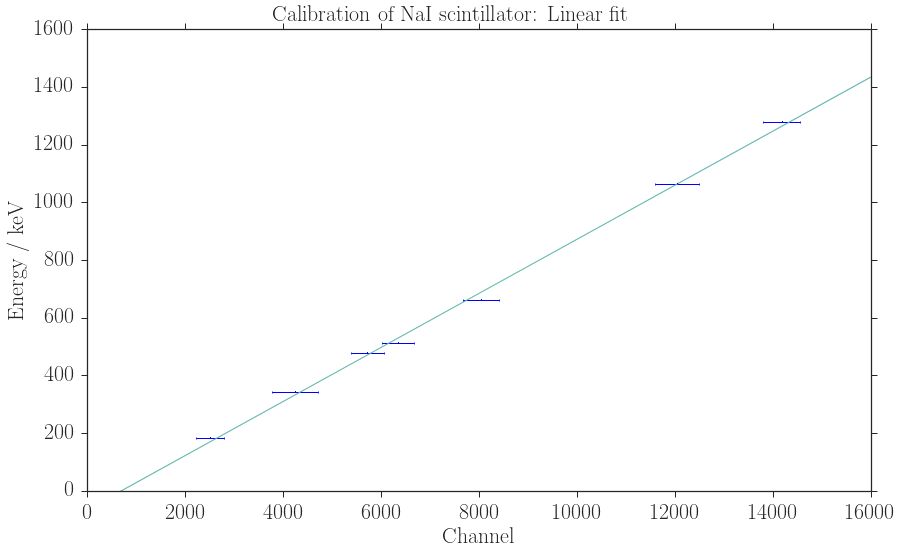

In [22]:
# Plotting
colors = ['b', 'g', 'r', 'pink']
channel_min, channel_max = [0, 16000]
chs = np.linspace(channel_min, channel_max, 200)
fit = linear(chs, *d_lin)

fig1, ax1 = plt.subplots(1, 1)
if not save_fig:
    fig1.suptitle('Calibration of NaI scintillator: Linear fit')
ax1.fill_between(chs, 
        un.nominal_values(fit) + un.std_devs(fit),
        un.nominal_values(fit) - un.std_devs(fit),
        facecolor=colors[0], color=colors[0], alpha=0.2)
ax1.plot(chs, un.nominal_values(fit), '-', linewidth=1.0)  

ax1.errorbar(channel, energy, xerr=channel_error, yerr=None, fmt='b,',
             elinewidth=1.0, capsize=1.2, capthick=0.8)
ax1.set_xlim(channel_min, channel_max)
ax1.set_ylim(0,)
ax1.set_xlabel("Channel")
ax1.set_ylabel("Energy / keV")
#ax1.legend(loc=1)
if save_fig:
    file_name = "calibration_na_linear_fit"
    fig1.savefig(fig_dir + file_name + ".pdf")
    fig1.savefig(fig_dir + file_name + ".png")
